In [1]:
import os
import sys
import numpy as np
from scipy import signal
%matplotlib inline
# import pickle
import time
import neuron
from neuron import h
from neuron import gui
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
import plotly
plt.rcParams.update({'font.size': 15})

!nrnivmodl /home/mjy/project/bilinear_network/2021Neuron/L5PC/mods

h.load_file('nrngui.hoc')
h.load_file("import3d.hoc")

morphologyFilename = "morphologies/cell1.asc"
biophysicalModelFilename = "L5PCbiophys5b.hoc"
biophysicalModelTemplateFilename = "L5PCtemplate_2.hoc"

h.load_file(biophysicalModelFilename)
h.load_file(biophysicalModelTemplateFilename)
L5PC = h.L5PCtemplate(morphologyFilename)

--No graphics will be displayed.


/home/mjy/project/bilinear_network/2021Neuron/L5PC
cfiles =
Mod files: "/home/mjy/project/bilinear_network/2021Neuron/L5PC/mods/CaDynamics_E2.mod" "/home/mjy/project/bilinear_network/2021Neuron/L5PC/mods/Ca_HVA.mod" "/home/mjy/project/bilinear_network/2021Neuron/L5PC/mods/Ca_LVAst.mod" "/home/mjy/project/bilinear_network/2021Neuron/L5PC/mods/epsp.mod" "/home/mjy/project/bilinear_network/2021Neuron/L5PC/mods/Ih.mod" "/home/mjy/project/bilinear_network/2021Neuron/L5PC/mods/Im.mod" "/home/mjy/project/bilinear_network/2021Neuron/L5PC/mods/K_Pst.mod" "/home/mjy/project/bilinear_network/2021Neuron/L5PC/mods/K_Tst.mod" "/home/mjy/project/bilinear_network/2021Neuron/L5PC/mods/kv.mod" "/home/mjy/project/bilinear_network/2021Neuron/L5PC/mods/na.mod" "/home/mjy/project/bilinear_network/2021Neuron/L5PC/mods/Nap_Et2.mod" "/home/mjy/project/bilinear_network/2021Neuron/L5PC/mods/NaTa_t.mod" "/home/mjy/project/bilinear_network/2021Neuron/L5PC/mods/NaTs2_t.mod" "/home/mjy/project/bilinear_network/2021N

In [2]:
from neuron import h
import numpy as np
from collections import defaultdict

def list_mechanisms_and_gbars():
    h.define_shape()

    density_mechs = set()
    point_procs = set()
    # 收集每个 gbar 参数的统计
    gstats = {}  # key: (mech, param) -> dict

    for sec in h.allsec():
        ps = sec.psection()

        # density mechanisms
        for mech in ps.get('density_mechs', {}).keys():
            density_mechs.add(mech)

        # point processes
        for pp_name in ps.get('point_processes', {}).keys():
            point_procs.add(pp_name)

    # 初始化统计容器：对每个 mech 的 gbar* 做面积加权统计
    # 注意：不同机制不一定叫 gbar，有的叫 g、gmax、pbar 等；这里先抓 gbar*
    for sec in h.allsec():
        for seg in sec:
            A = seg.area()  # um^2
            # 遍历所有 density mechanisms，查看这个 seg 上是否有该机制 & 是否有 gbar 字段
            for mech in density_mechs:
                try:
                    mobj = getattr(seg, mech)  # seg.hh / seg.pas / ...
                except Exception:
                    continue

                # 找出该机制对象上所有以 gbar 开头的属性
                for attr in dir(mobj):
                    if attr.startswith("gbar"):
                        key = (mech, attr)
                        val = float(getattr(mobj, attr))
                        if key not in gstats:
                            gstats[key] = {
                                "area_sum": 0.0,
                                "weighted_sum": 0.0,
                                "min": val,
                                "max": val,
                                "count": 0
                            }
                        st = gstats[key]
                        st["area_sum"] += A
                        st["weighted_sum"] += val * A
                        st["min"] = min(st["min"], val)
                        st["max"] = max(st["max"], val)
                        st["count"] += 1

    # 输出结果
    density_mechs = sorted(list(density_mechs))
    point_procs = sorted(list(point_procs))

    gbar_summary = []
    for (mech, param), st in sorted(gstats.items()):
        mean_area_weighted = st["weighted_sum"] / st["area_sum"] if st["area_sum"] > 0 else np.nan
        gbar_summary.append({
            "mechanism": mech,
            "param": param,
            "mean_area_weighted": mean_area_weighted,
            "min": st["min"],
            "max": st["max"],
            "n_samples": st["count"]
        })

    return density_mechs, point_procs, gbar_summary

density_mechs, point_procs, gbar_summary = list_mechanisms_and_gbars()

print("Density mechanisms (#={}):".format(len(density_mechs)))
print(density_mechs[:50], "..." if len(density_mechs) > 50 else "")

print("\nPoint processes (#={}):".format(len(point_procs)))
print(point_procs[:50], "..." if len(point_procs) > 50 else "")

print("\nFound gbar* parameters (#={}):".format(len(gbar_summary)))
for row in gbar_summary[:30]:
    print(row)


Density mechanisms (#=13):
['CaDynamics_E2', 'Ca_HVA', 'Ca_LVAst', 'Ih', 'Im', 'K_Pst', 'K_Tst', 'NaTa_t', 'NaTs2_t', 'Nap_Et2', 'SK_E2', 'SKv3_1', 'pas'] 

Point processes (#=0):
[] 

Found gbar* parameters (#=0):


In [2]:
# 收集所有 dendritic sections（排除 axon）
dend_secs = []
soma_secs = []

for sec in h.allsec():
    name = sec.name()
    if 'soma' in name:
        soma_secs.append(sec)
    elif 'dend' in name or 'apic' in name:
        dend_secs.append(sec)

print(f"# soma sections: {len(soma_secs)}")
print(f"# dendritic sections: {len(dend_secs)}")


# soma sections: 1
# dendritic sections: 193


In [3]:
from collections import defaultdict

children = defaultdict(list)
parent = {}

for sec in dend_secs:
    sr = h.SectionRef(sec=sec)
    if sr.has_parent():
        p = sr.parent
        parent[sec] = p
        children[p].append(sec)
    else:
        parent[sec] = None


In [4]:
branch_points = [
    sec for sec, childs in children.items()
    if sec in dend_secs and len(childs) >= 2
]

print(f"# dendritic branch points: {len(branch_points)}")


# dendritic branch points: 92


In [5]:
tips = [
    sec for sec in dend_secs
    if sec not in children or len(children[sec]) == 0
]

print(f"# dendritic tips: {len(tips)}")


# dendritic tips: 101


In [6]:
primary_dendrites = [
    sec for sec in dend_secs
    if parent[sec] in soma_secs
]

print(f"# primary dendrites: {len(primary_dendrites)}")


# primary dendrites: 9


In [7]:
# 单位：μm
lengths = np.array([sec.L for sec in dend_secs])

total_length = lengths.sum()
mean_length = lengths.mean()
max_length = lengths.max()

print(f"Total dendritic length: {total_length:.1f} μm")
print(f"Mean section length: {mean_length:.1f} μm")
print(f"Max section length: {max_length:.1f} μm")


Total dendritic length: 12574.4 μm
Mean section length: 65.2 μm
Max section length: 276.4 μm


In [8]:
def branch_depth(sec):
    depth = 0
    while parent.get(sec) not in (None,) + tuple(soma_secs):
        sec = parent[sec]
        depth += 1
    return depth

depths = np.array([branch_depth(sec) for sec in dend_secs])

print(f"Max branch order: {depths.max()}")
print(f"Mean branch order: {depths.mean():.2f}")


Max branch order: 15
Mean branch order: 6.02


In [3]:
h.load_file('nrngui.hoc')
h.load_file("import3d.hoc")

morphologyFilename = "morphologies/cell1.asc"
biophysicalModelFilename = "L5PCbiophys5b.hoc"
biophysicalModelTemplateFilename = "L5PCtemplate_2.hoc"

h.load_file(biophysicalModelFilename)
h.load_file(biophysicalModelTemplateFilename)
L5PC = h.L5PCtemplate(morphologyFilename)

845.34678 
845.34678 


number of synapses: 100
number of synapses: 500


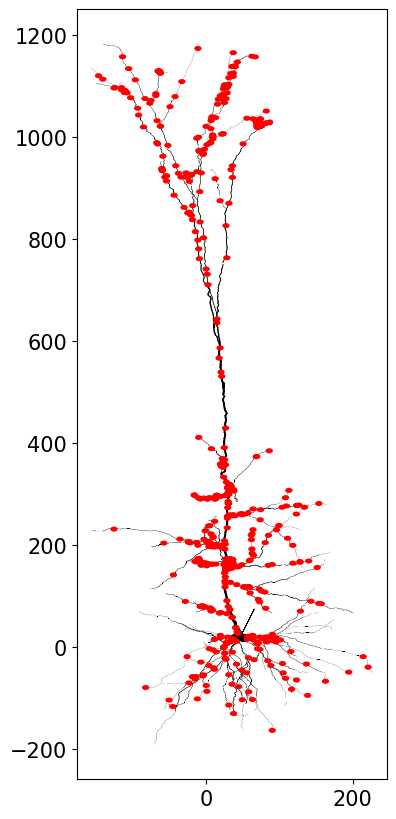

In [4]:
nsyn = 100
cell_secs = []
for sec in h.allsec(): 
    cell_secs.append(sec)
    sec.nseg = 100

locs = np.empty((100, 2))
for i in range(len(locs)):
    locs[i, 0] = int(np.random.randint(83))
    locs[i, 1] = np.random.random()
# Add dummy compartments at synapse locations
synapses = []
print ('number of synapses:', nsyn)
for s in np.arange(0,nsyn):
    synapses.append(h.Section())
    synapses[s].L = 5# 1e-6
    synapses[s].diam = 1#1e-6
    idend = int(locs[s,0])
    if (idend > -1):
        synapses[s].connect(L5PC.dend[idend], int(locs[s,1]), 0)
    else :
        synapses[s].connect(L5PC.soma, 0.5, 0)
#----------------------------------------------------------------------------
# Get numbers for plotting cell morphology
# cell: [xstart xend ystart yend diamstart diamend]
# synapse: [x, y]
h.define_shape()
cell_coordinates = []
for sec in cell_secs:
    sec.push()
    for stepCount in np.arange(1, h.n3d()):
        stepCount =  float(stepCount)
        cell_coordinates.append([h.x3d(stepCount-1), h.x3d(stepCount),
                                h.y3d(stepCount-1), h.y3d(stepCount),
                                    h.diam3d(stepCount-1), h.diam3d(stepCount)])
    h.pop_section()

set_dends = set(locs[:,0])

# I don't know how to work with sets, so convert it to an array
set_dends = np.array(list(set_dends))
dend_coord = []
for i_dend in np.arange(0,len(set_dends)):
    syn_coordinates = []
    d_dend = int(set_dends[i_dend])
    if (d_dend > -1):
        L5PC.dend[d_dend].push()
    else :
        L5PC.soma.push()
    for stepCount in np.arange(1, h.n3d()):
        stepCount =  float(stepCount)
        syn_coordinates.append([h.x3d(stepCount-1), h.x3d(stepCount),
                                h.y3d(stepCount-1), h.y3d(stepCount), 
                                h.diam3d(stepCount-1), h.diam3d(stepCount)])
    h.pop_section()
    dend_coord.append(syn_coordinates)
#----------------------------------------------------------------------------
# Make plot
plt.figure(figsize=(4, 10))
# Cell
for pt in np.arange(len(cell_coordinates)):
    xstart, xend = cell_coordinates[pt][0], cell_coordinates[pt][1]
    ystart, yend = cell_coordinates[pt][2], cell_coordinates[pt][3]
    lx = xend-xstart
    ly = yend-ystart
    l = np.sqrt(np.dot([lx,ly],[lx,ly]))
    diamstart = cell_coordinates[pt][4] / 2
    diamend = cell_coordinates[pt][5] / 2

    if diamstart > 8: diamstart=diamstart/3.5
    if diamend > 8: diamend=diamend/3.5

    if l>0:
        plt.fill([xstart+2*diamstart*ly/(2*l), xend+2*diamend*ly/(2*l),
                    xend-2*diamend*ly/(2*l), xstart-2*diamstart*ly/(2*l)], 
                    [ystart-2*diamstart*lx/(2*l), yend-2*diamend*lx/(2*l),
                    yend+2*diamend*lx/(2*l), ystart+2*diamstart*lx/(2*l)],
                    'k', lw=0) 

    c1 = plt.Circle((xstart, ystart), diamstart, color='k', lw=0)
    c2 = plt.Circle((xend, yend), diamend, color='k', lw=0) 
    plt.gca().add_patch(c1)
    plt.gca().add_patch(c2)
    
# Synapses
# nsyn_d = data.Ensyn
nsyn_d = [100]
#if (plotInh): nsyn_d = nsyn_d + [sum(data.Insyn)] # all inhibitory synapses are plotted with the same color 


idsyn = nsyn_d[:]
for ii in np.arange(len(idsyn)):
    idsyn[ii] = sum(nsyn_d[0:(ii+1)])

ecols13 = ['#6d4022', '#a05e32',
            '#512100', '#883600', '#b44800', '#e35b00', '#ff802b',
            '#715b00', '#ac8a00', '#d4aa00', '#f9c800',
            '#6d6649', '#a89f7d']     
ecols4 = ['#6d4022', '#b44800', '#d4aa00', '#a89f7d']     
ecols1 = ['#a05e32']
     
# if (len(data.Ensyn)==13):
#         ecols = ecols13
# elif (len(data.Ensyn)==4):
#         ecols = ecols4
# elif (len(data.Ensyn)==1):
#         ecols = ecols1

ecols = ['#a05e32']

#else : # a colormap with random colors for each cluster
cmap = cm.get_cmap(name="jet")
# nden = len(data.Ensyn)
nden = len(nsyn_d)
ecols = [None] * nden
np.random.seed(seed=16)
for icol in np.arange(nden):
    icc = np.random.randint(256)
    ecols[icol] = colors.rgb2hex(cmap(icc))
icols = ['#000000']
# print (ecols)
# print (idsyn)
for syn in np.arange(nsyn):
    # select the branch for the synapse
    idend = int(locs[syn,0])
    iidend = int(np.argwhere(set_dends == idend))
    syn_coordinates = dend_coord[iidend]
    ptmax=np.shape(syn_coordinates)[0]
    # find the coordinates along the branch
    ptt = locs[syn,1] * ptmax
    pt = int(np.floor(ptt))
    ptd = ptt - pt
    xstart, xend = syn_coordinates[pt][0], syn_coordinates[pt][1]
    ystart, yend = syn_coordinates[pt][2], syn_coordinates[pt][3]
    lx = xend-xstart
    ly = yend-ystart
    x = xstart + lx * ptd
    y = ystart + lx * ptd
    # nEsyn = sum(data.Ensyn)
    nEsyn = 600
    if (syn < nEsyn):
        iden = -1
        for ii in np.arange(len(idsyn)):
                if syn >= idsyn[ii]: iden = ii
        iden = iden + 1
        # print (syn, iden)
        colsyn = ecols[iden]
         # c = plt.Circle((x,y), 3, color=colsyn, lw=0)
        # Assign color based on the index of the synapse
        if syn < nsyn / 2:
            color = 'red'  # First half are red
        else:
            color = 'red'  # Second half are black

        # Create and add the circle to the plot
        c = plt.Circle((x, y), 5, color=color, lw=0)
    else :
        # c = plt.Circle((x,y), 3, color=icols[0], lw=2)
        # Assign color based on the index of the synapse
        if syn < nsyn / 2:
            color = 'red'  # First half are red
        else:
            color = 'red'  # Second half are black

        # Create and add the circle to the plot
        c = plt.Circle((x, y), 5, color=color, lw=0)
    plt.gca().add_patch(c)
#-----------------------------------------

# add synapses on the apic

#-----------------------------------------
nsyn = 500
cell_secs = []
for sec in h.allsec(): 
    cell_secs.append(sec)
    sec.nseg = 100

locs = np.empty((500, 2))
for i in range(len(locs)):
    locs[i, 0] = int(np.random.randint(108))
    locs[i, 1] = np.random.random()
# Add dummy compartments at synapse locations
synapses = []
print ('number of synapses:', nsyn)
for s in np.arange(0,nsyn):
    synapses.append(h.Section())
    synapses[s].L = 5# 1e-6
    synapses[s].diam = 1#1e-6
    idend = int(locs[s,0])
    if (idend > -1):
        synapses[s].connect(L5PC.apic[idend], int(locs[s,1]), 0)
    else :
        synapses[s].connect(L5PC.soma, 0.5, 0)
#----------------------------------------------------------------------------
# Get numbers for plotting cell morphology
# cell: [xstart xend ystart yend diamstart diamend]
# synapse: [x, y]
h.define_shape()
cell_coordinates = []
for sec in cell_secs:
    sec.push()
    for stepCount in np.arange(1, h.n3d()):
        stepCount =  float(stepCount)
        cell_coordinates.append([h.x3d(stepCount-1), h.x3d(stepCount),
                                h.y3d(stepCount-1), h.y3d(stepCount),
                                    h.diam3d(stepCount-1), h.diam3d(stepCount)])
    h.pop_section()

set_dends = set(locs[:,0])

# I don't know how to work with sets, so convert it to an array
set_dends = np.array(list(set_dends))
dend_coord = []
for i_dend in np.arange(0,len(set_dends)):
    syn_coordinates = []
    d_dend = int(set_dends[i_dend])
    if (d_dend > -1):
        L5PC.apic[d_dend].push()
    else :
        L5PC.soma.push()
    for stepCount in np.arange(1, h.n3d()):
        stepCount =  float(stepCount)
        syn_coordinates.append([h.x3d(stepCount-1), h.x3d(stepCount),
                                h.y3d(stepCount-1), h.y3d(stepCount), 
                                h.diam3d(stepCount-1), h.diam3d(stepCount)])
    h.pop_section()
    dend_coord.append(syn_coordinates)
    
# Synapses
# nsyn_d = data.Ensyn
nsyn_d = [0]
#if (plotInh): nsyn_d = nsyn_d + [sum(data.Insyn)] # all inhibitory synapses are plotted with the same color 


idsyn = nsyn_d[:]
for ii in np.arange(len(idsyn)):
    idsyn[ii] = sum(nsyn_d[0:(ii+1)])

ecols13 = ['#6d4022', '#a05e32',
            '#512100', '#883600', '#b44800', '#e35b00', '#ff802b',
            '#715b00', '#ac8a00', '#d4aa00', '#f9c800',
            '#6d6649', '#a89f7d']     
ecols4 = ['#6d4022', '#b44800', '#d4aa00', '#a89f7d']     
ecols1 = ['#a05e32']
     
# if (len(data.Ensyn)==13):
#         ecols = ecols13
# elif (len(data.Ensyn)==4):
#         ecols = ecols4
# elif (len(data.Ensyn)==1):
#         ecols = ecols1

ecols = ['#a05e32']

#else : # a colormap with random colors for each cluster
cmap = cm.get_cmap(name="jet")
# nden = len(data.Ensyn)
nden = len(nsyn_d)
ecols = [None] * nden
np.random.seed(seed=16)
for icol in np.arange(nden):
    icc = np.random.randint(256)
    ecols[icol] = colors.rgb2hex(cmap(icc))
icols = ['#000000']
# print (ecols)
# print (idsyn)
for syn in np.arange(nsyn):
    # select the branch for the synapse
    idend = int(locs[syn,0])
    iidend = int(np.argwhere(set_dends == idend))
    syn_coordinates = dend_coord[iidend]
    ptmax=np.shape(syn_coordinates)[0]
    # find the coordinates along the branch
    ptt = locs[syn,1] * ptmax
    pt = int(np.floor(ptt))
    ptd = ptt - pt
    xstart, xend = syn_coordinates[pt][0], syn_coordinates[pt][1]
    ystart, yend = syn_coordinates[pt][2], syn_coordinates[pt][3]
    lx = xend-xstart
    ly = yend-ystart
    x = xstart + lx * ptd
    y = ystart + lx * ptd
    # nEsyn = sum(data.Ensyn)
    nEsyn = 600
    if (syn < nEsyn):
        iden = -1
        for ii in np.arange(len(idsyn)):
                if syn >= idsyn[ii]: iden = ii
        iden = iden + 1
        # print (syn, iden)
        if iden >= len(ecols):
            print(f"Warning: iden ({iden}) is out of bounds for ecols with length {len(ecols)}")
            iden = len(ecols) - 1  # Use the last color as a fallback
        colsyn = ecols[iden]

        # c = plt.Circle((x,y), 3, color=colsyn, lw=0)
        # Assign color based on the index of the synapse
        if syn < nsyn / 2:
            color = 'red'  # First half are red
        else:
            color = 'red'  # Second half are black

        # Create and add the circle to the plot
        c = plt.Circle((x, y), 5, color=color, lw=0)
    else :
        # c = plt.Circle((x,y), 3, color=icols[0], lw=2)
        # Assign color based on the index of the synapse
        if syn < nsyn / 2:
            color = 'red'  # First half are red
        else:
            color = 'red'  # Second half are black

        # Create and add the circle to the plot
        c = plt.Circle((x, y), 5, color=color, lw=0)
    plt.gca().add_patch(c)      

# plt.axis('equal')
# plt.xlim(-200,200)
# plt.ylim(-160,240)
plt.savefig('figure/colored_synapse_red.png', dpi=800, bbox_inches='tight')
plt.show()


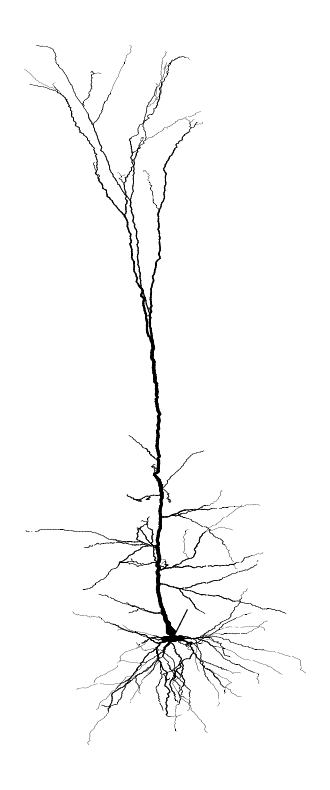

In [4]:
cell_secs = []
for sec in h.allsec(): 
    cell_secs.append(sec)
    sec.nseg = 100

locs = np.empty((100, 2))
for i in range(len(locs)):
    locs[i, 0] = int(np.random.randint(83))
    locs[i, 1] = np.random.random()
#----------------------------------------------------------------------------
# Get numbers for plotting cell morphology
# cell: [xstart xend ystart yend diamstart diamend]
# synapse: [x, y]
h.define_shape()
cell_coordinates = []
for sec in cell_secs:
    sec.push()
    for stepCount in np.arange(1, h.n3d()):
        stepCount =  float(stepCount)
        cell_coordinates.append([h.x3d(stepCount-1), h.x3d(stepCount),
                                h.y3d(stepCount-1), h.y3d(stepCount),
                                    h.diam3d(stepCount-1), h.diam3d(stepCount)])
    h.pop_section()

set_dends = set(locs[:,0])

# I don't know how to work with sets, so convert it to an array
set_dends = np.array(list(set_dends))
dend_coord = []
for i_dend in np.arange(0,len(set_dends)):
    syn_coordinates = []
    d_dend = int(set_dends[i_dend])
    if (d_dend > -1):
        L5PC.dend[d_dend].push()
    else :
        L5PC.soma.push()
    for stepCount in np.arange(1, h.n3d()):
        stepCount =  float(stepCount)
        syn_coordinates.append([h.x3d(stepCount-1), h.x3d(stepCount),
                                h.y3d(stepCount-1), h.y3d(stepCount), 
                                h.diam3d(stepCount-1), h.diam3d(stepCount)])
    h.pop_section()
    dend_coord.append(syn_coordinates)
#----------------------------------------------------------------------------

# Make plot
plt.figure(figsize=(4, 10))
# Cell
for pt in np.arange(len(cell_coordinates)):
    xstart, xend = cell_coordinates[pt][0], cell_coordinates[pt][1]
    ystart, yend = cell_coordinates[pt][2], cell_coordinates[pt][3]
    lx = xend-xstart
    ly = yend-ystart
    l = np.sqrt(np.dot([lx,ly],[lx,ly]))
    diamstart = cell_coordinates[pt][4] / 1.2 # 2
    diamend = cell_coordinates[pt][5] / 1.2  # 2

    if diamstart > 8: diamstart=diamstart/2.5 # 3.5
    if diamend > 8: diamend=diamend/2.5 # 3.5

    if l>0:
        plt.fill([xstart+2*diamstart*ly/(2*l), xend+2*diamend*ly/(2*l),
                    xend-2*diamend*ly/(2*l), xstart-2*diamstart*ly/(2*l)], 
                    [ystart-2*diamstart*lx/(2*l), yend-2*diamend*lx/(2*l),
                    yend+2*diamend*lx/(2*l), ystart+2*diamstart*lx/(2*l)],
                    'k', lw=5) 

    c1 = plt.Circle((xstart, ystart), diamstart, color='k', lw=0)
    c2 = plt.Circle((xend, yend), diamend, color='k', lw=0) 
    plt.gca().add_patch(c1)
    plt.gca().add_patch(c2)

plt.axis('off')
plt.savefig('figure/only_dendrite.pdf', bbox_inches='tight')
# plt.show()